# Advance Feature Engineering

### 1. Token Features

* cwc_min: This is the ratio of the number of common words to the length of the smaller question
* cwc_max: This is the ratio of the number of common words to the length of the larger question
* ctc_min: This is the ratio of the number of common tokens to the smaller token count among the two questions
* ctc_max: This is the ratio of the number of common tokens to the larger token count among the two questions
* last_word_eq: 1 if the last word in the two questions is same, 0 otherwise
* first_word_eq: 1 if the first word in the two questions is same, 0 otherwise

### 2. Length Based Features

* mean_len: Mean of the length of the two questions (number of words)
* abs_len_diff: Absolute difference between the length of the two questions (number of words)
* longest_substr_ratio: Ratio of the length of the longest substring among the two questions to the length of the smaller question

### 3. Fuzzy Features

* fuzz_ratio: fuzz_ratio score from fuzzywuzzy
* fuzz_partial_ratio: fuzz_partial_ratio from fuzzywuzzy
* token_sort_ratio: token_sort_ratio from fuzzywuzzy
* token_set_ratio: token_set_ratio from fuzzywuzzy

In [1]:
import pandas as pd
import distance
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

In [2]:
data=pd.read_csv(r"C:\Users\asus\Documents\Projects\Question_Similarity_Pairs\Input\basic_feature.csv")

In [3]:
# Token Features

def cwc_min(ws,val1,val2):
    c_len=min(val1,val2)
    return ws/c_len

def cwc_max(ws,val1,val2):
    c_len=max(val1,val2)
    return ws/c_len

def ctc_min(q1,q2):
    q1_list=q1.split()
    q2_list=q2.split()
    com_token=len(set(q1_list).intersection(set(q2_list)))
    min_tok=min(len(q1_list),len(q2_list))
    return com_token/min_tok

def ctc_max(q1,q2):
    q1_list=q1.split()
    q2_list=q2.split()
    com_token=len(set(q1_list).intersection(set(q2_list)))
    max_tok=max(len(q1_list),len(q2_list))
    return com_token/max_tok

def last_word_eq(q1,q2):
    q1_last_word=q1.split()[-1]
    q2_last_word=q2.split()[-1]
    if(q1_last_word==q2_last_word):
        return 1
    return 0

def first_word_eq(q1,q2):
    q1_first_word=q1.split()[0]
    q2_first_word=q2.split()[0]
    if(q1_first_word==q2_first_word):
        return 1
    return 0





In [4]:
# Length based features

def longest_substr_ratio(val1,val2):
    m=list(distance.lcsubstrings(val1,val2))
    if(m==[]):
        ls=0
    else:
        ls=len(m[0].split())
    
    return ls/min(len(val1.split()),len(val2.split()))




In [5]:
#Fuzzy based features
from fuzzywuzzy import fuzz
def fuzzy_features(row):
    q1=row['question1']
    q2=row['question2']

    fuzz_feat=[0.0]*4

    #fuzzy ratio
    fuzz_feat[0]=fuzz.QRatio(q1,q2)

    #fuzzy partial ratio
    fuzz_feat[1]=fuzz.partial_ratio(q1,q2)

    #token sort ratio
    fuzz_feat[2]=fuzz.token_set_ratio(q1,q2)

    #token set ratio
    fuzz_feat[3]=fuzz.token_sort_ratio(q1,q2)

    return fuzz_feat




In [6]:
data['cwc_min']=data[['word_share','q1_wordcount','q2_wordcount']].apply(lambda x:cwc_min(*x),axis=1)
data['cwc_max']=data[['word_share','q1_wordcount','q2_wordcount']].apply(lambda x:cwc_max(*x),axis=1)
data['ctc_min']=data[['question1','question2']].apply(lambda x:ctc_min(*x),axis=1)
data['ctc_max']=data[['question1','question2']].apply(lambda x:ctc_max(*x),axis=1)
data['last_word_eq']=data[['question1','question2']].apply(lambda x:last_word_eq(*x),axis=1)
data['first_word_eq']=data[['question1','question2']].apply(lambda x:first_word_eq(*x),axis=1)
#using Length based features
data['mean_len']=data[['q1_wordcount','q2_wordcount']].apply(lambda x:(x[0]+x[1])/2,axis=1)
data['abs_len_diff']=data[['q1_wordcount','q2_wordcount']].apply(lambda x:abs(x[0]-x[1]),axis=1)
data['longest_substr_ratio']=data[['question1','question2']].apply(lambda x:longest_substr_ratio(*x),axis=1)
#using Fuzzy based features
val=data.apply(fuzzy_features,axis=1)
data['fuzzy_ratio']=list(map(lambda x:x[0],val))
data['fuzzy_partial_ratio']=list(map(lambda x:x[1],val))
data['token_set_ratio']=list(map(lambda x:x[2],val))
data['token_sort_ratio']=list(map(lambda x:x[3],val))


In [7]:
data.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,len_ques1,len_ques2,q1_wordcount,q2_wordcount,...,ctc_max,last_word_eq,first_word_eq,mean_len,abs_len_diff,longest_substr_ratio,fuzzy_ratio,fuzzy_partial_ratio,token_set_ratio,token_sort_ratio
0,0,1,2,step step guid invest share market india,step step guid invest share market,0,40,34,7,6,...,0.714286,0,1,6.5,1,1.00,92,100,100,92
1,1,3,4,stori kohinoor kohinoor diamond,would happen indian govern stole kohinoor kohi...,0,31,63,4,9,...,0.222222,0,0,6.5,5,0.75,62,94,84,62


In [8]:
data.shape

(404154, 24)

* Let's just do some EDA to find more about the data after the addition of advanced featurization

In [9]:
list_of_adv_features=['cwc_min','cwc_max','ctc_min','ctc_max','last_word_eq','first_word_eq','mean_len','abs_len_diff','longest_substr_ratio','fuzzy_ratio','fuzzy_partial_ratio','token_set_ratio','token_sort_ratio','is_duplicate']

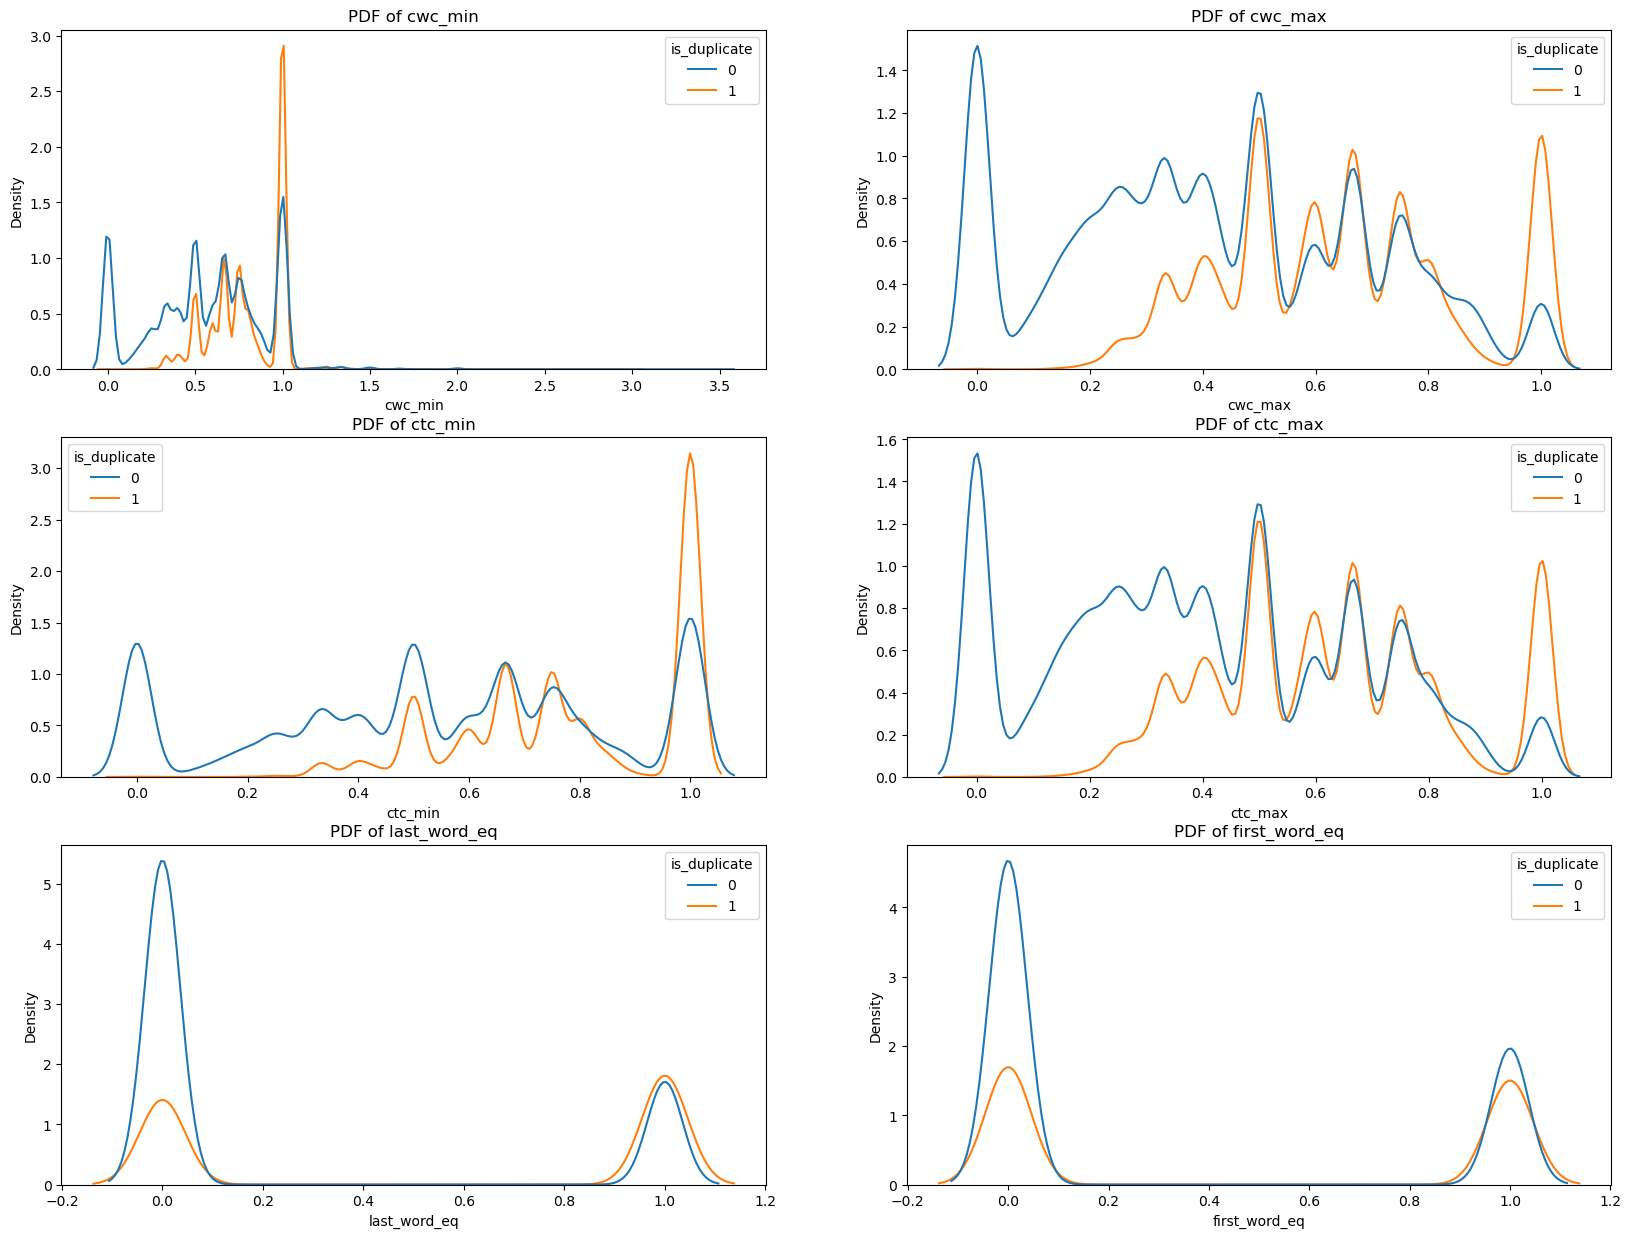

In [10]:
#pdf for token based features
fig,ax=plt.subplots(3,2,figsize=(20,15))
ax[0,0].title.set_text('PDF of cwc_min')
ax[0,1].title.set_text('PDF of cwc_max')
ax[1,0].title.set_text('PDF of ctc_min')
ax[1,1].title.set_text('PDF of ctc_max')
ax[2,0].title.set_text('PDF of last_word_eq')
ax[2,1].title.set_text('PDF of first_word_eq')
sns.kdeplot(data,x='cwc_min',hue='is_duplicate',ax=ax[0,0])
sns.kdeplot(data,x='cwc_max',hue='is_duplicate',ax=ax[0,1])
sns.kdeplot(data,x='ctc_min',hue='is_duplicate',ax=ax[1,0])
sns.kdeplot(data,x='ctc_max',hue='is_duplicate',ax=ax[1,1])
sns.kdeplot(data,x='last_word_eq',hue='is_duplicate',ax=ax[2,0])
sns.kdeplot(data,x='first_word_eq',hue='is_duplicate',ax=ax[2,1])
plt.show()


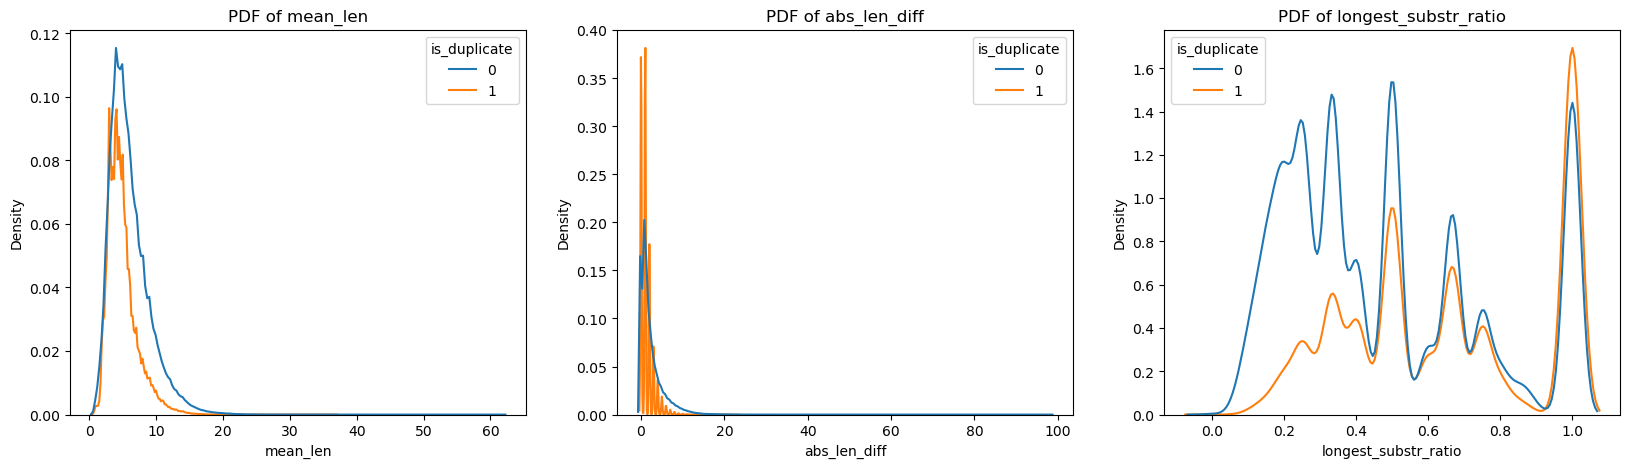

In [11]:
#pdf for token based features
fig,ax=plt.subplots(1,3,figsize=(20,5))
ax[0].title.set_text('PDF of mean_len')
ax[1].title.set_text('PDF of abs_len_diff')
ax[2].title.set_text('PDF of longest_substr_ratio')

sns.kdeplot(data,x='mean_len',hue='is_duplicate',ax=ax[0])
sns.kdeplot(data,x='abs_len_diff',hue='is_duplicate',ax=ax[1])
sns.kdeplot(data,x='longest_substr_ratio',hue='is_duplicate',ax=ax[2])

plt.show()


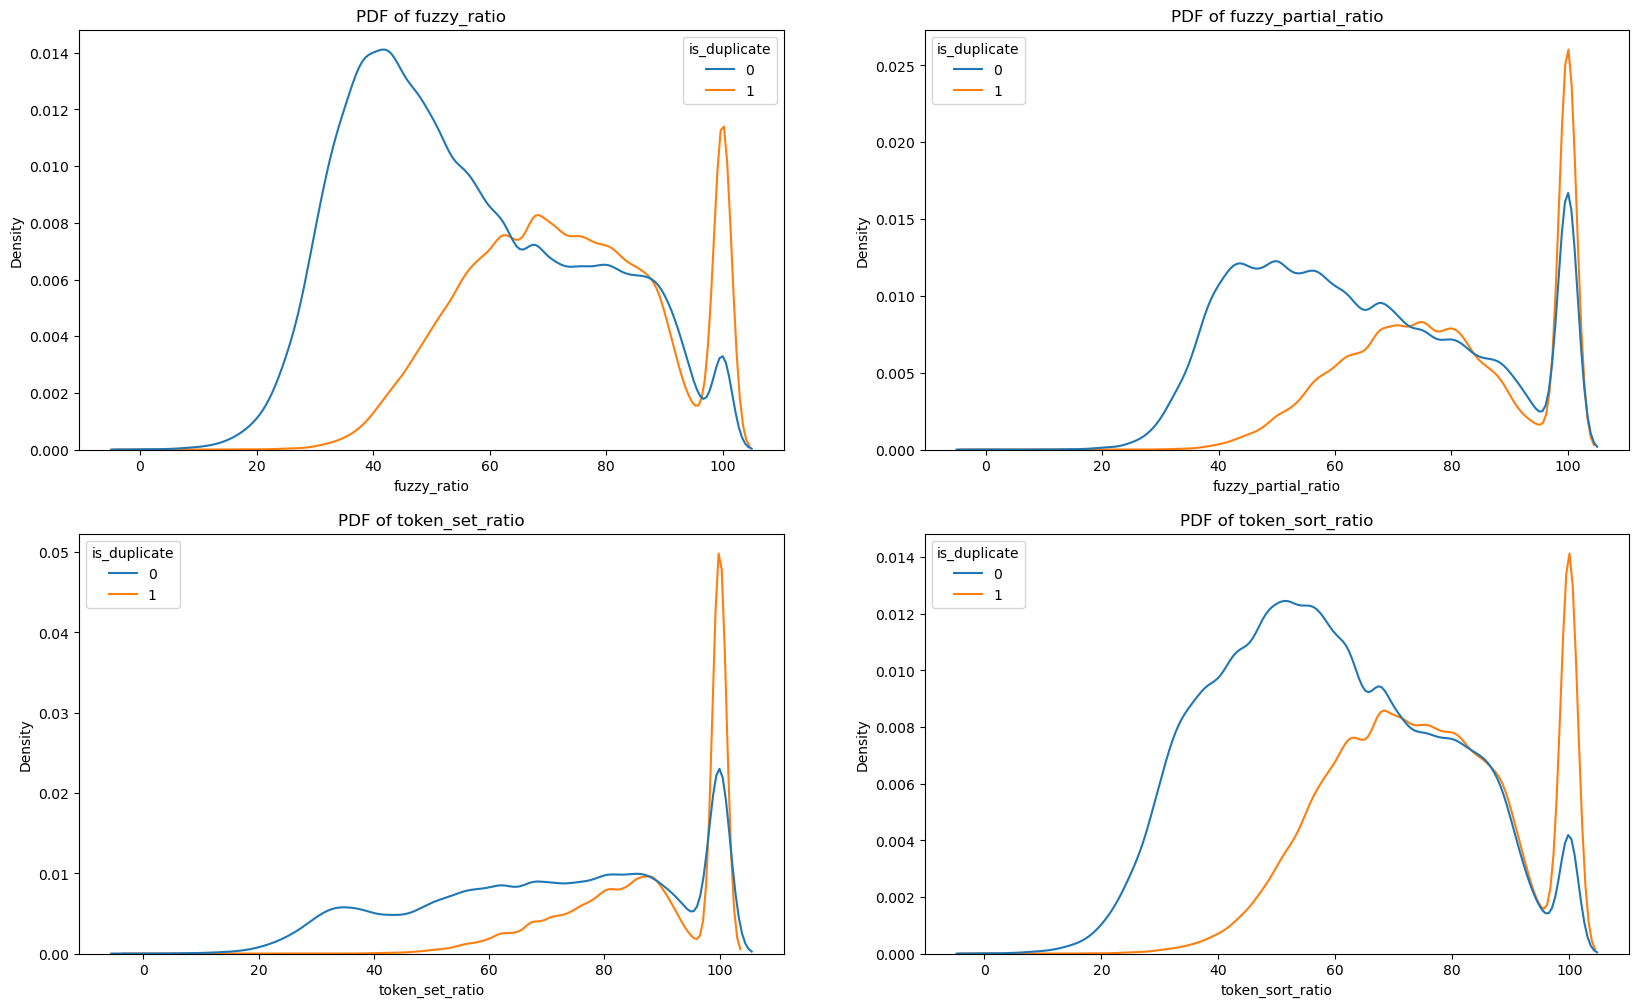

In [12]:
#pdf of fuzzy based features
fig,ax=plt.subplots(2,2,figsize=(20,12))
ax[0,0].title.set_text('PDF of fuzzy_ratio')
ax[0,1].title.set_text('PDF of fuzzy_partial_ratio')
ax[1,0].title.set_text('PDF of token_set_ratio')
ax[1,1].title.set_text('PDF of token_sort_ratio')

sns.kdeplot(data,x='fuzzy_ratio',hue='is_duplicate',ax=ax[0,0])
sns.kdeplot(data,x='fuzzy_partial_ratio',hue='is_duplicate',ax=ax[0,1])
sns.kdeplot(data,x='token_set_ratio',hue='is_duplicate',ax=ax[1,0])
sns.kdeplot(data,x='token_sort_ratio',hue='is_duplicate',ax=ax[1,1])

plt.show()

### Observation:

* We can clearly see a good sense of separation between <b>is_duplicate classes</b> in all the PDFs of advance features 

#### Now let's do some modelling and try of find its perfomance now

In [13]:
cv=CountVectorizer(max_features=30)
ques_list=list(data['question1'])+list(data['question2'])
q1,q2=np.vsplit(cv.fit_transform(ques_list).toarray(),2)
ques_1=pd.DataFrame(q1,index=data.index)
ques_2=pd.DataFrame(q2,index=data.index)
tot_list=pd.concat([ques_1,ques_2],axis=1)
tot_list.shape



(404154, 60)

In [14]:
temp_data=data[['len_ques1','len_ques2','q1_wordcount','q2_wordcount','word_share','cwc_min','cwc_max','ctc_min','ctc_max','last_word_eq','first_word_eq','mean_len','abs_len_diff','longest_substr_ratio','fuzzy_ratio','fuzzy_partial_ratio','token_set_ratio','token_sort_ratio','is_duplicate']]
data_df=pd.concat([temp_data,tot_list],axis=1)
data_df.shape

(404154, 79)

In [15]:
X,Y=data_df.drop('is_duplicate',axis=1),data_df['is_duplicate']

In [16]:
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.1,stratify=Y,random_state=42)


In [17]:
rf_model=RandomForestClassifier(n_estimators=50)
rf_model.fit(X_train,Y_train)

c:\Users\asus\anaconda3\envs\Quora\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


RandomForestClassifier(n_estimators=50)

In [18]:
import warnings
warnings.filterwarnings('ignore')
#Calculate train accuracy
print("Train accuracy: ",accuracy_score(Y_train,rf_model.predict(X_train)))
#Calculate test accuracy
print("Test accuracy: ",accuracy_score(Y_test,rf_model.predict(X_test)))

Train accuracy:  0.9675315749248086
Test accuracy:  0.7704621931908155


In [19]:
grid={
    'max_features':[20,30],
    'max_depth':[15,20]
}

In [20]:
best_rf=GridSearchCV(rf_model,param_grid=grid,cv=2)
best_rf.fit(X_train,Y_train)

GridSearchCV(cv=2, estimator=RandomForestClassifier(n_estimators=50),
             param_grid={'max_depth': [15, 20], 'max_features': [20, 30]})

In [21]:
import warnings
warnings.filterwarnings('ignore')
#Calculate train accuracy
print("Train accuracy: ",accuracy_score(Y_train,best_rf.predict(X_train)))
#Calculate test accuracy
print("Test accuracy: ",accuracy_score(Y_test,best_rf.predict(X_test)))

Train accuracy:  0.8306005971331013
Test accuracy:  0.7642765241488519


In [22]:
best_rf.best_estimator_

RandomForestClassifier(max_depth=20, max_features=20, n_estimators=50)

In [23]:
best_rf.predict_proba(X_train)

array([[0.7497019 , 0.2502981 ],
       [0.24205119, 0.75794881],
       [0.62772751, 0.37227249],
       ...,
       [0.89431251, 0.10568749],
       [0.95490806, 0.04509194],
       [0.05958003, 0.94041997]])